In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [2]:
dataset_path = './dataset/SB-FishDisease'

img_fish = []

folders = os.listdir(dataset_path)

for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    img_fish.extend([os.path.join(folder_path, file) for file in os.listdir(folder_path)])

train, val = train_test_split(img_fish, test_size=0.2, random_state=42)



In [3]:
print("Train:", train[:5])
print("Val:", val[:5])

Train: ['./dataset/SB-FishDisease\\Bacterial Red disease\\Bacterial_Red disease_31.jpg', './dataset/SB-FishDisease\\Bacterial diseases - Aeromoniasis\\Bacterial_diseases _Aeromoniasis _32.jpg', './dataset/SB-FishDisease\\Bacterial gill disease\\Bacterial_gill disease_38.jpg', './dataset/SB-FishDisease\\Healthy Fish\\Healthy_Fish_57.jpg', './dataset/SB-FishDisease\\Parasitic diseases\\Parasitic_diseases_28.jpg']
Val: ['./dataset/SB-FishDisease\\Bacterial Red disease\\Bacterial_Red disease_45.jpg', './dataset/SB-FishDisease\\Healthy Fish\\Healthy_Fish_47.jpg', './dataset/SB-FishDisease\\Fungal diseases Saprolegniasis\\Fungal_diseases_Saprolegniasis_30.jpg', './dataset/SB-FishDisease\\Viral diseases White tail disease\\Viral_diseases_White_tail_disease_29.jpg', './dataset/SB-FishDisease\\Viral diseases White tail disease\\Viral_diseases_White_tail_disease_38.jpg']


In [4]:
# train_df = pd.DataFrame({
#     "filepath": train,
#     "label": ["1"] * len(train)  # Fisk finns
# })

# val_df = pd.DataFrame({
#     "filepath": val,
#     "label": ["1"] * len(val)
# })

# train_df["label"] = ["0"] * len(train)  # Fisk lyser med sin frånvaro
# val_df["label"] = ["0"] * len(val)


In [5]:
train_df = pd.DataFrame({
    "filepath": train,
    "label": ["1"] * len(train)  # Fish is present
})

val_df = pd.DataFrame({
    "filepath": val,
    "label": ["1"] * len(val)  # Fish is present
})

# For images without fish, label should be '0'
train_df.loc[train_df['label'] == '1', 'label'] = '0'
val_df.loc[val_df['label'] == '1', 'label'] = '0'

## Lets go!

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

Found 337 validated image filenames belonging to 1 classes.
Found 84 validated image filenames belonging to 1 classes.


c:\Users\emmel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(
c:\Users\emmel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, output)

#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=4,  
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/4


11/11 [==============================] - 26s 2s/step - loss: 0.0775 - accuracy: 0.9614 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/4
11/11 [==============================] - 19s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/4
11/11 [==============================] - 19s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/4
11/11 [==============================] - 19s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [10]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_generator))
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

3/3 [==============================] - 3s 956ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000


In [11]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_generator))
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Use the trained model to make predictions on some validation data
sample_images, sample_labels = next(val_generator)
predictions = model.predict(sample_images)

# Convert the predictions to class labels
predicted_classes = (predictions > 0.5).astype(int)

# Print actual labels and predicted labels for the first few samples
print("Actual labels:", sample_labels[:5])
print("Predicted labels:", predicted_classes[:5])

3/3 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000
1/1 [==============================] - 3s 3s/step
Actual labels: [0. 0. 0. 0. 0.]
Predicted labels: [[0]
 [0]
 [0]
 [0]
 [0]]


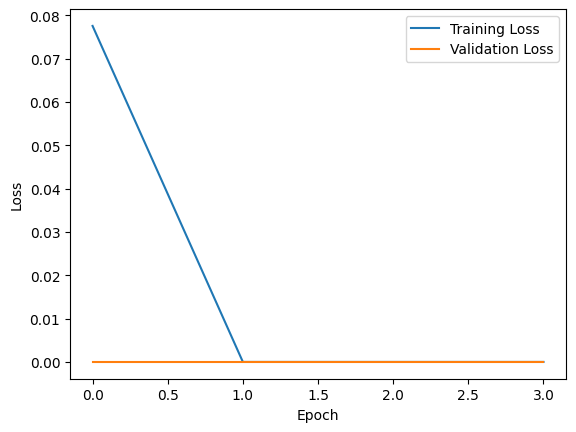

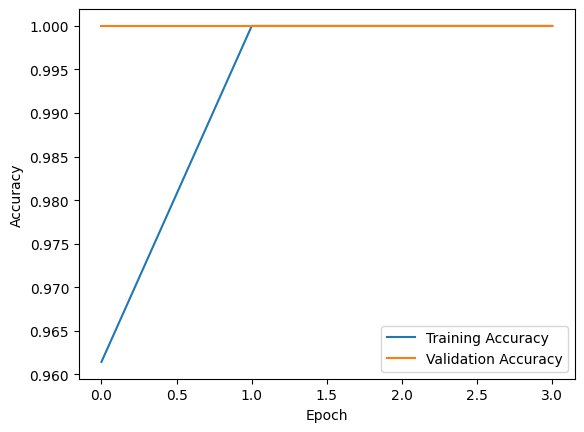

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Test:

In [13]:
test_img_path = 'dataset/test_img/sick_fishy_1.jpg'

1/1 [==============================] - 1s 1s/step


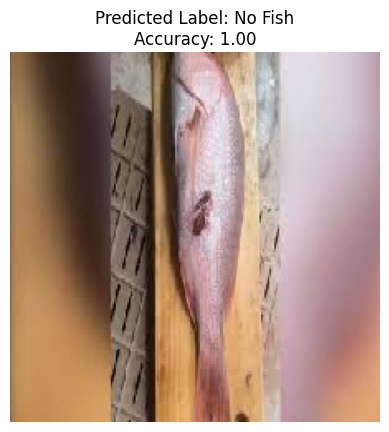

In [14]:
# Load and preprocess the test image
img = image.load_img(test_img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values

# Make a prediction using the trained model
prediction = model.predict(img_array)

# Display the image
plt.imshow(img)
plt.axis('off')

# Display the predicted label and its accuracy
predicted_label = "Fish" if prediction[0][0] > 0.5 else "No Fish"
accuracy = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

plt.title(f'Predicted Label: {predicted_label}\nAccuracy: {accuracy:.2f}')
plt.show()